# Packages import

In [1]:
import numpy as np
import scipy as sp
import os
import pandas as pd

import matplotlib.pyplot as plt
from my_package import my_functions  as mp
import warnings
from PIL import Image
import skimage

warnings.filterwarnings('ignore')
%matplotlib inline

## Paths and filenames

In [2]:
Fields_DataPath = '../../Gamaya_Data_Science_Assignment_v1_3_short/ts.csv'

## Data collection

In [3]:
# read Fields data
Fields_Data = pd.read_csv(Fields_DataPath, header=0)

# formating data
Fields_Data.timestamp = pd.to_datetime(Fields_Data.date, format='%Y-%m-%d')
Fields_Data.index = Fields_Data.timestamp
Fields_Data.drop('date', axis=1, inplace=True)

# check Timedeltas and deal with missing data
TimeDiff = [(Fields_Data.timestamp[i+1] - Fields_Data.timestamp[i]) for i in range(len(Fields_Data)-1)]
print(np.unique(TimeDiff))

# Restore data
Fields_Data = Fields_Data.reindex(pd.date_range(
    start=Fields_Data.index[0], end=Fields_Data.index[-1], freq='12d'))
Fields_Data = Fields_Data.interpolate(method='linear')
Fields_Data.timestamp = pd.to_datetime(Fields_Data.index, format='%Y-%m-%d')

# Check restoration process
TimeDiff = [(Fields_Data.index[i+1] - Fields_Data.index[i]) for i in range(len(Fields_Data)-1)]
print(np.unique(TimeDiff))

[Timedelta('12 days 00:00:00') Timedelta('24 days 00:00:00')]
[Timedelta('12 days 00:00:00')]


             field_1   field_2   field_3   field_4   field_5
2017-01-07  0.183835  0.259682  0.197566  0.210799  0.261180
2017-01-19  0.238601  0.339112  0.281340  0.256515  0.256587
2017-01-31  0.198846  0.258195  0.213687  0.299293  0.325990
2017-02-12  0.198963  0.223632  0.195405  0.208886  0.206241
2017-02-24  0.189429  0.192786  0.140357  0.158054  0.144746


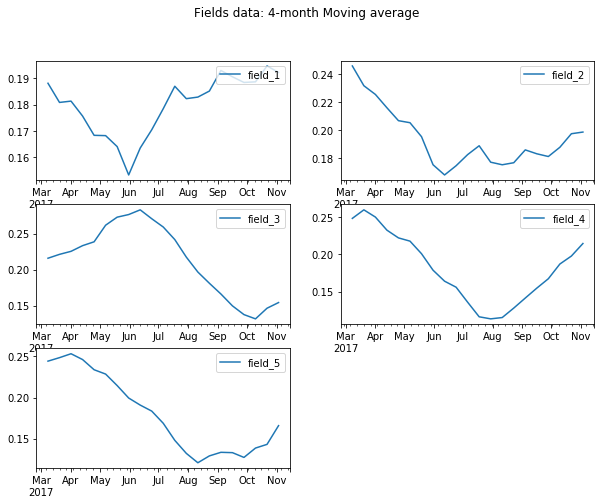

In [4]:
# display data sample
fig, axes = plt.subplots(3,2, figsize=(15,10))
fig.suptitle('Field data')
axes = fig.axes
for i in range(Fields_Data.shape[1]):
    ax = Fields_Data[Fields_Data.keys()[i]].plot(ax = axes[i])
    ax.legend(loc='upper right')
axes[5].axis('off')
print(Fields_Data.head())

# display averaged sample
fig, axes = plt.subplots(3,2, figsize=(10,7.5))
fig.suptitle('Fields data: 4-month Moving average')
axes = fig.axes
for i in range(Fields_Data.shape[1]):
    ax = Fields_Data[Fields_Data.keys()[i]].rolling(10).mean(center=True).plot(ax = axes[i])
    ax.legend(loc='upper right')
axes[5].axis('off');
plt.savefig('4M_movingAv.png', bbox_inches='tight', transparent=True)

# Stationary or non-stationary 

## Augmented Dickey Fuller

In [5]:
for k in Fields_Data.keys():
    print(k + ':')
    mp.Print_Dickey_test(Fields_Data[k].reindex(pd.date_range(
    start=Fields_Data.index[0], end=Fields_Data.index[-1], freq='1d')).interpolate(method='linear'), Autolag=None)
    print('='*10)

field_1:
Test Statistic                     -3.382029
P-value                             0.011587
Used Lags                          17.000000
Number of Observations Used       331.000000
MacKinnon Critical Value (1%)      -3.450262
MacKinnon Critical Value (5%)      -2.870312
MacKinnon Critical Value (10%)     -2.571443
dtype: float64
field_2:
Test Statistic                     -3.281356
P-value                             0.015733
Used Lags                          17.000000
Number of Observations Used       331.000000
MacKinnon Critical Value (1%)      -3.450262
MacKinnon Critical Value (5%)      -2.870312
MacKinnon Critical Value (10%)     -2.571443
dtype: float64
field_3:
Test Statistic                     -1.996928
P-value                             0.287922
Used Lags                          17.000000
Number of Observations Used       331.000000
MacKinnon Critical Value (1%)      -3.450262
MacKinnon Critical Value (5%)      -2.870312
MacKinnon Critical Value (10%)     -2.57144

# kpss

In [6]:
for k in Fields_Data.keys():
    print(k + ':')
    mp.kpss_test(Fields_Data[k].reindex(pd.date_range(
    start=Fields_Data.index[0], end=Fields_Data.index[-1], freq='1d')).interpolate(method='linear'))
    print('='*10)

field_1:
Test Statistic            0.1489
p-value                   0.1000
Lags Used                17.0000
Critical Value (10%)      0.3470
Critical Value (5%)       0.4630
Critical Value (2.5%)     0.5740
Critical Value (1%)       0.7390
dtype: float64
field_2:
Test Statistic            0.415826
p-value                   0.070333
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
field_3:
Test Statistic            0.446265
p-value                   0.057214
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
field_4:
Test Statistic            0.413210
p-value                   0.071461
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)  

C:\Users\selim\Anaconda3\envs\GamaEnvs\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


# Break date detection

In [7]:
fig, axes = plt.subplots(3,2, figsize=(10,8))
fig.suptitle('Backward differeces aplied on smoothed Fields data')
axes = fig.axes
DropDate = []
for i, k in enumerate(Fields_Data.keys()):
    DropDate.append(mp.Get_Breakdate_bySignal(Fields_Data[k], DoPlot=True, ax=axes[i]))
axes[-1].axis('off');
plt.savefig('Figures/BackDiff.png', bbox_inches='tight', transparent=True)

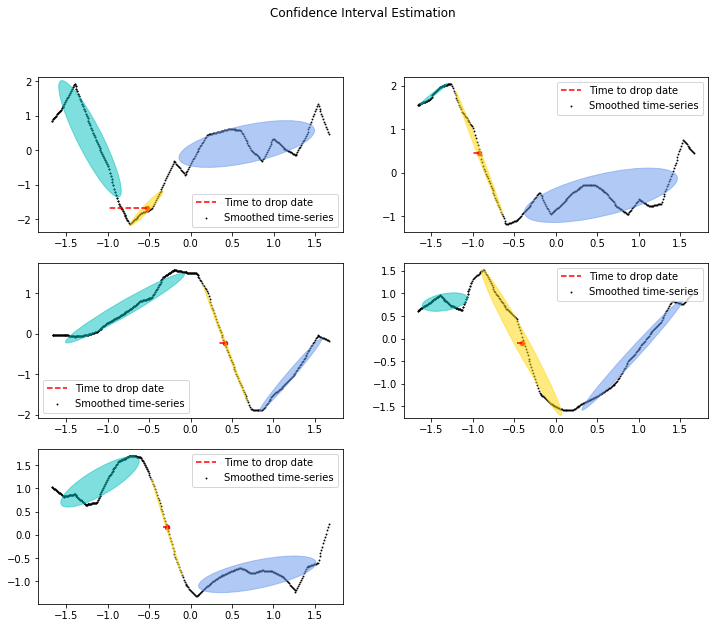

In [15]:
# Initilize Scores dictionnary
scores = {}
for k in Fields_Data.keys():
    scores[k] = []

# Produce 50 Run and plot only one
fig, axes = plt.subplots(3,2, figsize=(12,9.7))
fig.suptitle('Confidence Interval Estimation')
axes = fig.axes
for r in range(100):
    for i, k in enumerate(Fields_Data.keys()):
        results = mp.Get_FreeGMM(Fields_Data[k], DropDate[i], n_cp=3)
        scores[k].append(results[-1].predict_proba([results[-1].means_init[1]])[0][1])
    
        # Plot only one
        if r == 8:
            mp.plot_results(results[0][2:-2,:], 
                         results[3][2:-2], 
                         results[1], 
                         results[2], 
                         DropPos=results[-1].means_init[1], 
                         ax=axes[i], 
                         title='')
axes[5].axis('off');

# Averaged run scores
for k in Fields_Data.keys():
    if np.sum(np.array(scores[k])!=1)==0:
        scores[k] = (1.0, (1.0,1.0))
    else:
        scores[k] =  sp.stats.bayes_mvs(scores[k])[0][:]
        
plt.savefig('Figures/GaussianFit.png', bbox_inches='tight', transparent=True)

In [16]:
# Display Confidence interval of Probability
for k in Fields_Data.keys():
    print("Average Probability to belong to the droping gaussian : {0:f}, 90% Confidence Int. ({1:f}:{2:f})"
          .format(scores[k][0], scores[k][1][0], scores[k][1][1]))

Average Probability to belong to the droping gaussian : 0.124288, 90% Confidence Int. (0.070288:0.178288)
Average Probability to belong to the droping gaussian : 0.850000, 90% Confidence Int. (0.790413:0.909587)
Average Probability to belong to the droping gaussian : 1.000000, 90% Confidence Int. (1.000000:1.000000)
Average Probability to belong to the droping gaussian : 0.989064, 90% Confidence Int. (0.985413:0.992714)
Average Probability to belong to the droping gaussian : 0.880000, 90% Confidence Int. (0.825772:0.934228)
